In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import math
import scipy.stats as stats
# from scipy.optimize import curve_fit

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn.preprocessing as prep
import sklearn.metrics as metrics
from sklearn import model_selection

from rfpimp import dropcol_importances
from rfpimp import importances

import pickle

c:\program files\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Helper Functions

#### Helper functions for plotting

In [4]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, 
                     trend_line=False, trend_order=1, trend_color=None, 
                     title='', length_label='', tick_labels='', tick_axis_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        labels = []
        for i, lab in enumerate(bars):
            if bar_labels=='':
                labels.append([f"{j:.4f}" for j in cells[i]])
            else:
                labels.append(bar_labels[i])
#             labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_xticklabels(cols)
        else:
            ax.set_xticklabels(tick_labels)
        if not length_label=='':
            ax.set_ylabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_xlabel(tick_axis_label, fontsize=12, fontweight='bold')
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_yticklabels(cols)
        else:
            ax.set_yticklabels(tick_labels)
        if not length_label=='':
            ax.set_xlabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_ylabel(tick_axis_label, fontsize=12, fontweight='bold')
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title, fontsize=14, fontweight='bold')
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    ax.grid(True, axis='y')

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True, annotate=False, annot_kwargs=8):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=annotate,
                annot_kws={'size': annot_kwargs})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None, xticklabels=None, yticklabels=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = np.array([[i for j in range(len(n_classes))] for i in n_classes])
        norm_matrix = conf_matrix / n_matrix
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               n_matrix[i, j]) for j, v in enumerate(norm_matrix[i])] for i, v in enumerate(norm_matrix)])
        _xticklabels=('auto' if xticklabels is None else xticklabels)
        _yticklabels=('auto' if yticklabels is None else yticklabels)
        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, 
                    xticklabels=_xticklabels, yticklabels=_yticklabels)
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels='auto', yticklabels='auto')

    ax.set_ylabel('True Labels', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Labels', fontsize=12, fontweight='bold')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values
    
def plot_mae_deciles(model, X, y_true, y_bl, index, ax, log_transform=False, cumulative=False, title=None):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y_bl = np.exp(y_bl.values) - 1
    y = np.stack([y_pred, y_true], axis=1)
    y = pd.DataFrame(y, columns=['predicted_y', 'true_y'])

    y['mae_model'] = np.abs(y['true_y'] - y['predicted_y'])
    y['mean_y_baseline'] = np.mean(y_bl)
    y['mae_naive'] = np.abs(y['true_y'] - y['mean_y_baseline'])
    y = y[['mean_y_baseline', 'predicted_y', 'true_y', 'mae_model', 'mae_naive']].sort_values(by='mae_model', ascending=True)
    y['deciles'] = pd.qcut(y['mae_model'], 10, labels=False, duplicates='drop')

    mae_model = []
    mae_naive = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            mae_model.append(np.mean(y.loc[y['deciles']<=i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']<=i, 'mae_naive']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population')
            ax.set_ylabel('Mean absolute error \n (cumulative mean)')
        else:
            mae_model.append(np.mean(y.loc[y['deciles']==i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']==i, 'mae_naive']))
            ax.set_xlabel('Deciles')
            ax.set_ylabel('Mean absolute error \n (mean per decile)')
    data = np.stack([mae_model, mae_naive], axis=1)
    data = pd.DataFrame(data, columns=['mae_model', 'mae_naive'])

    _x = data.index
    _y = data['mae_model'].values
    ax.plot(_x, _y, marker='o', color='b')
    
    _y = data['mae_naive']
    ax.plot(_x, _y, marker='o', color='r')
    
    ax.legend(['Model predictions', 'Naive predictions'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    if log_transform:
        ax.set_yscale('log')
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.05])
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_deciles_data(data, figname='', color='dimgrey', plot_type='bar', trend_line=False, trend_order=1, trend_color='dimgrey', cumulative_pop=False, data_labels=False, x_label=None, y_label=None):
    grd = list(data.columns)
    grd_n = len(grd)
    grd_cols_n = 2
    grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

    plt_h = 4
    plt_w = 12
    
    fig_ttl = plt.figure()
    fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
    ax0 = fig_ttl.add_subplot()
    ax0.text(0.5, 0.5, figname, fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax0.axis('off')

    fig = plt.figure()
    fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
    gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

    for idx, col in enumerate(list(data.columns)):
        if data_labels:
            labs = ['{0:.2f}'.format(i) for i in data[col]]
            bar_labels=[labs]
        else:
            bar_labels=None
        
        if cumulative_pop:
            tick_labels = np.arange(10,110,10)
        else:
            tick_labels = list(data.index)
        
        if x_label is not None:
            tick_axis_label = x_label
        else:
            tick_axis_label = ''
        if y_label is not None:
            length_label = y_label
        else:
            length_label = col
        
        if plot_type=='bar':
            plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                             data=data[col].to_frame().T,
                             bar_labels=bar_labels,
                             tick_labels = tick_labels,
                             plots_labels=None,
                             plots_colors=[color],
                             width=0.3,
                             trend_line=trend_line, 
                             trend_order=trend_order, 
                             trend_color=[trend_color],
                             title=None,
                             tick_axis_label=tick_axis_label,
                             length_label=length_label,
                             orient='v',
                             spines={'top': False, 'right': False})
        elif plot_type=='scatter':
            ax=fig.add_subplot(gs[idx])
            _x = tick_labels
            _y = data[col].values
            ax.scatter(_x, _y, marker='o', color=color)
            z = np.polyfit(_x, _y, 2)
            p = np.poly1d(z)
            ax.plot(_x, p(_x), color=color)
            
def plot_cls_ratio_deciles(models, Xs, ys_true, indexes, ax, by_class=1, cumulative=False, title=None, legend=None, colors=None):
    deciles = []
    _legend = []
    for idx, model in enumerate(models):
        y_pred = model.predict(Xs[idx])
        y_prob = model.predict_proba(Xs[idx])
        y_true = ys_true[idx]

        y_byclass = np.stack([y_true, y_pred, y_prob[:,by_class]], axis=1)
        y_byclass = pd.DataFrame(y_byclass, index=indexes[idx], columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
        y_dec = np.zeros(len(y_true))
        n = len(y_dec) // 10
        N = 10 * n
        for i in range(0, N, n):
            if i==N:
                y_dec[i:] = i/n
            else:
                y_dec[i:i+n] = i/n
        y_byclass['deciles'] = y_dec
        y_byclass['deciles'] = y_byclass['deciles'].astype('int32')

        dec_labs = y_byclass['deciles'].unique()
        correct_pred_rate_byclass = []
#         correct_pred_rate_othclass = []
        for i in dec_labs:
            dec_samples = (y_byclass.loc[y_byclass['deciles']<=i] if cumulative else y_byclass.loc[y_byclass['deciles']==i])
            n_true_byclass = len(dec_samples.loc[dec_samples['true_y']==by_class])
            n_correct_pred_byclass = len(dec_samples.loc[(dec_samples['true_y']==by_class) & (dec_samples['predicted_y']==by_class)])
            correct_pred_rate_byclass.append(n_correct_pred_byclass / n_true_byclass)
            
#             n_true_othclass = len(dec_samples.loc[dec_samples['true_y']!=by_class])
#             n_correct_pred_othclass = len(dec_samples.loc[(dec_samples['true_y']!=by_class) & (dec_samples['predicted_y']!=by_class)])
#             correct_pred_rate_othclass.append(n_correct_pred_othclass / n_true_othclass)
        
        y_othclass = np.stack([y_true, y_pred, y_prob[:,np.abs(by_class-1)]], axis=1)
        y_othclass = pd.DataFrame(y_othclass, index=indexes[idx], columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
        y_dec = np.zeros(len(y_true))
        n = len(y_dec) // 10
        N = 10 * n
        for i in range(0, N, n):
            if i==N:
                y_dec[i:] = i/n
            else:
                y_dec[i:i+n] = i/n
        y_othclass['deciles'] = y_dec
        y_othclass['deciles'] = y_othclass['deciles'].astype('int32')

        dec_labs = y_othclass['deciles'].unique()
#         correct_pred_rate_byclass = []
        correct_pred_rate_othclass = []
        for i in dec_labs:
            dec_samples = (y_othclass.loc[y_othclass['deciles']<=i] if cumulative else y_othclass.loc[y_othclass['deciles']==i])
#             n_true_byclass = len(dec_samples.loc[dec_samples['true_y']==by_class])
#             n_correct_pred_byclass = len(dec_samples.loc[(dec_samples['true_y']==by_class) & (dec_samples['predicted_y']==by_class)])
#             correct_pred_rate_byclass.append(n_correct_pred_byclass / n_true_byclass)
            
            n_true_othclass = len(dec_samples.loc[dec_samples['true_y']!=by_class])
            n_correct_pred_othclass = len(dec_samples.loc[(dec_samples['true_y']!=by_class) & (dec_samples['predicted_y']!=by_class)])
            correct_pred_rate_othclass.append(n_correct_pred_othclass / n_true_othclass)

        _x = np.arange(10)
        _y_byclass = np.array(correct_pred_rate_byclass)
        _y_othclass = np.array(correct_pred_rate_othclass)
        _colors = ([list(mcolors.TABLEAU_COLORS.keys())[idx], 
                    list(mcolors.TABLEAU_COLORS.keys())[len(mcolors.TABLEAU_COLORS.keys())-1-idx]] if colors is None else colors[idx])
        ax.plot(_x, _y_byclass, marker='o', color=_colors[0])
        ax.plot(_x, _y_othclass, marker='o', color=_colors[1])
        
        _legend.append('model {0} target class'.format(idx))
        _legend.append('model {0} other class'.format(idx))
        deciles.append(y_byclass['deciles'])
    
    ax.set_xticks(np.arange(10))
    
    if cumulative:
        ax.set_xticklabels(np.arange(10,110,10))
        ax.set_xlabel('% of population', fontsize=14, fontweight='bold')
        ax.set_ylabel('Correct predictions rate \n (per % of population)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels(np.arange(1,11))
        ax.set_xlabel('Deciles', fontsize=14, fontweight='bold')
        ax.set_ylabel('Correct predictions rate \n (per decile)', fontsize=12, fontweight='bold')
    
    if legend is None:
        legend = _legend
    ax.legend(legend)
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    ax.grid(True)

    return deciles

def plot_diagram_xy(data, x, y, ax, x_title=None, y_title=None, x_labels_format='{0:.2f}', title=None, pot_size=None):
    _data = data.copy()
    _data = _data.sort_values(by=x, ascending=False)
    _data['qcut'] = pd.cut(_data[x], 10, labels=False, duplicates='drop')

    cuts = _data['qcut'].unique()
    _x = np.zeros(len(cuts))
    _y = np.zeros(len(cuts))
    for idx, i in enumerate(cuts):
        _x[len(cuts)-1-idx] = np.mean(_data.loc[_data['qcut']==i, x])
        _y[len(cuts)-1-idx] = np.mean(_data.loc[_data['qcut']==i, y])
    plot_bar_diagram(ax=ax,
                     data=pd.Series(_y).to_frame().T,
                     tick_labels=[x_labels_format.format(i) for i in _x],
                     bar_labels=None,
                     orient='v',
                     width=0.3,
                     title=('{0} vs {1}'.format(y,x) if title is None else title),
                     length_label=(y if y_title is None else y_title),
                     tick_axis_label=(x if x_title is None else x_title),
                     plots_colors=['tab:blue'],
                     spines={'top': False, 'right': False})
    
def get_lift_chart_proba(model, X, y_true, by_class=1):
#     y_pred = model.predict(X)
#     y_prob = model.predict_proba(X)

#     y = np.stack([y_true, y_pred, y_prob[:,by_class]], axis=1)
#     y = pd.DataFrame(y, columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
#     y['deciles'] = pd.qcut(y['proba_y'], 10, labels=False, duplicates='drop')
#     y['deciles'] = y['deciles'].apply(lambda x: 9-x)
    
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
#     y_true = ys_true[idx]

    y = np.stack([y_true, y_pred, y_prob[:,1]], axis=1)
    y = pd.DataFrame(y, columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    def p_cum_sum(arr_n, arr_p, pos):
        arr = []
        for i in range(pos + 1):
            arr.append(arr_p[i] * arr_n[i])
        return np.sum(arr)

    dec_labs = y['deciles'].unique()
    total_mean_proba = np.mean(y['proba_y'])
    n_samples = []
    dec_mean_proba = []
    dec_lift_ovr_mean = []
    n_cum_samples = []
    cum_mean_proba = []
    cum_lift_ovr_mean = []
    for i in dec_labs:
        dec_samples = y.loc[y['deciles']==i]

        n = len(dec_samples)
        p = np.mean(dec_samples['proba_y'])
        lift_ovr = p / total_mean_proba - 1

        n_samples.append(n)
        dec_mean_proba.append(p)
        dec_lift_ovr_mean.append(lift_ovr)

        n_cum = len(y.loc[y['deciles']<=i])
        p_cum = (p if i==0 else p_cum_sum(n_samples, dec_mean_proba, i) / n_cum)
        lift_ovr_cum = p_cum / total_mean_proba - 1

        n_cum_samples.append(n_cum)
        cum_mean_proba.append(p_cum)
        cum_lift_ovr_mean.append(lift_ovr_cum)
    lift = np.stack([n_samples, dec_mean_proba, dec_lift_ovr_mean, n_cum_samples, cum_mean_proba, cum_lift_ovr_mean], axis=1)
    return total_mean_proba, pd.DataFrame(lift, columns=['n_samples', 'dec_mean_proba', 'dec_lift_ovr_mean', 'n_cum_samples', 'cum_mean_proba', 'cum_lift_ovr_mean'])

#### Helper functions for model training

In [5]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring, fit_params=None):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, fit_params=fit_params, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print('CV results \n ===================================================')
    display(cv_res)
    print('\n Best parameters: ', best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

def dropcol_imp_precision_metric(model, X_valid, y_valid, sample_weights):
    y_pred = model.predict(X_valid)
    return metrics.precision_score(y_valid, y_pred, sample_weight=sample_weights)

def dropcol_imp_roc_auc_metric(model, X_valid, y_valid, sample_weights):
    y_pred = model.predict(X_valid)
    return metrics.roc_auc_score(y_valid, y_pred, sample_weight=sample_weights)

#### Load data

In [7]:
data_2018 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions18',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions18


In [8]:
data_2019 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions19',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions19


#### Drop refresh date column

In [12]:
data_2018 = data_2018.drop(columns=['refresh_date'])

In [13]:
data_2019 = data_2019.drop(columns=['refresh_date'])

#### Add target columns

In [14]:
data_2019.columns = [i + '_target' for i in list(data_2019.columns)]

In [15]:
data_2019 = data_2019.loc[data_2018.index]

In [16]:
data = pd.concat([data_2018, data_2019], axis=1)

#### Deal with NaNs

All data is numeric and and naturaly is equal or more than zero. So will fill nans with zeros.

In [17]:
data = data.fillna(value=0)

#### Drop samples that have negative sales and positive redemptions

In [18]:
# Inspect positive variables
f_pos = ['sales_12M_target',
         'AUM', 
         'sales_curr',         
         'sales_12M',
         'aum_AC_EQUITY',
         'aum_AC_FIXED_INCOME_MUNI',
         'aum_AC_FIXED_INCOME_TAXABLE',
         'aum_AC_MULTIPLE',
         'aum_AC_PHYSICAL_COMMODITY',
         'aum_AC_REAL_ESTATE',
         'aum_AC_TARGET',
         'aum_P_529',
         'aum_P_ETF',
         'aum_P_MF',
         'aum_P_SMA',
         'aum_P_UCITS',
         'aum_P_UIT']

for i in f_pos:
    print(i, len(data.loc[data[i] < 0]))

sales_12M_target 2
AUM 4377
sales_curr 4
sales_12M 7
aum_AC_EQUITY 3871
aum_AC_FIXED_INCOME_MUNI 3276
aum_AC_FIXED_INCOME_TAXABLE 1694
aum_AC_MULTIPLE 1149
aum_AC_PHYSICAL_COMMODITY 90
aum_AC_REAL_ESTATE 3
aum_AC_TARGET 19
aum_P_529 14
aum_P_ETF 5
aum_P_MF 4564
aum_P_SMA 1151
aum_P_UCITS 15
aum_P_UIT 42


In [19]:
# Inspect negative variables
f_neg = ['redemption_curr',
'redemption_12M']

for i in f_neg:
    print(i, len(data.loc[data[i] > 0]))

redemption_curr 3
redemption_12M 4


In [20]:
data = data.loc[(data['sales_12M']>=0) & 
         (data['sales_12M_target']>=0) & 
         (data['sales_curr']>=0) & 
         (data['redemption_curr']<=0) & 
         (data['redemption_12M']<=0)]

#### Reverse redemptions sign

In [23]:
for i in f_neg:
    data[i] = data[i].apply(np.abs)

#### Add delta_sales = sales_12M_2019 - sales_12M_2018

In [24]:
data['delta_sales_12M_18_19'] = (data['sales_12M_target'] - data['sales_12M'])

#### Add net sales data (net_sales = sales - redumptions)

In [25]:
net_cols = {'net_no_of_sales_12M_1': ['no_of_sales_12M_1', 'no_of_Redemption_12M_1'], 
            'net_no_of_sales_12M_10K': ['no_of_sales_12M_10K', 'no_of_Redemption_12M_10K'], 
            'net_no_of_funds_sold_12M_1': ['no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1'], 
            'net_no_of_fund_sales_12M_10K': ['no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K'], 
            'net_no_of_assetclass_sold_12M_1': ['no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1'], 
            'net_no_of_assetclass_sales_12M_10K': ['no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K']}

In [26]:
for net_col in net_cols.keys():
    data[net_col] = data[net_cols[net_col][0]] - data[net_cols[net_col][1]]

In [27]:
data['net_sales_curr'] = data['sales_curr'] - data['redemption_curr']
data['net_sales_12M'] = data['sales_12M'] - data['redemption_12M']

#### Split aum columns into positive and negative columns

In [28]:
aum_cols = []
for i in list(data.columns):
    if 'aum' in i:
        aum_cols.append(i)

In [29]:
for aum_col in aum_cols:
    data['pos_' + aum_col] = data[aum_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + aum_col] = data[aum_col].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Split net columns into positive and negative columns

In [30]:
for net_col in list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M']:
    data['pos_' + net_col] = data[net_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + net_col] = data[net_col].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Make a copy of data for post-processing

In [31]:
data_raw = data.copy()

#### Apply log-transform to continuous features

In [32]:
# Drop columns that have negative values
data = data.drop(columns=aum_cols)
data = data.drop(columns=['AUM'])
data = data.drop(columns=list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M'])

In [33]:
for i in ['sales_curr',
          'sales_12M',
          'redemption_curr',
          'redemption_12M',
          'pos_aum_AC_EQUITY',
          'neg_aum_AC_EQUITY',
          'pos_aum_AC_FIXED_INCOME_MUNI',
          'neg_aum_AC_FIXED_INCOME_MUNI',
          'pos_aum_AC_FIXED_INCOME_TAXABLE',
          'neg_aum_AC_FIXED_INCOME_TAXABLE',
          'pos_aum_AC_MONEY',
          'neg_aum_AC_MONEY',
          'pos_aum_AC_MULTIPLE',
          'neg_aum_AC_MULTIPLE',
          'pos_aum_AC_PHYSICAL_COMMODITY',
          'neg_aum_AC_PHYSICAL_COMMODITY',
          'pos_aum_AC_REAL_ESTATE',
          'neg_aum_AC_REAL_ESTATE',
          'pos_aum_AC_TARGET',
          'neg_aum_AC_TARGET',
          'pos_aum_P_529',
          'neg_aum_P_529',
          'pos_aum_P_ALT',
          'neg_aum_P_ALT',
          'pos_aum_P_CEF',
          'neg_aum_P_CEF',
          'pos_aum_P_ETF',
          'neg_aum_P_ETF',
          'pos_aum_P_MF',
          'neg_aum_P_MF',
          'pos_aum_P_SMA',
          'neg_aum_P_SMA',
          'pos_aum_P_UCITS',
          'neg_aum_P_UCITS',
          'pos_aum_P_UIT',
          'neg_aum_P_UIT',
          'pos_net_sales_curr',
          'pos_net_sales_12M',
          'neg_net_sales_curr',
          'neg_net_sales_12M']:
    data[i] = data[i].apply(lambda x: np.log(x+2))

#### Encode target feature

In [34]:
data['new_Fund_added_12M_target'] = data['new_Fund_added_12M_target'].apply(lambda x: 1 if x > 0 else 0)

#### Data summary

In [35]:
data_cols = ['sales_12M_target', 'new_Fund_added_12M_target']

In [36]:
for col in list(data.columns):
    if not col in data_cols:
        data_cols.append(col)

In [37]:
data = data[data_cols]

In [38]:
data_desc = data.describe().T
data_desc

,count,mean,std,min,25%,50%,75%,max
sales_12M_target,9988.0,211519.205077,1.139872e+06,0.000000,0.000000,87.575000,45143.376250,4.867638e+07
new_Fund_added_12M_target,9988.0,0.251502,4.338980e-01,0.000000,0.000000,0.000000,1.000000,1.000000e+00
no_of_sales_12M_1,9988.0,20.049760,9.849246e+01,0.000000,0.000000,0.000000,8.000000,4.395000e+03
no_of_Redemption_12M_1,9988.0,20.966860,1.917042e+02,0.000000,0.000000,1.000000,8.000000,1.215200e+04
no_of_sales_12M_10K,9988.0,2.415098,1.452724e+01,0.000000,0.000000,0.000000,1.000000,9.860000e+02
...,...,...,...,...,...,...,...,...
neg_net_no_of_assetclass_sales_12M_10K,9988.0,0.178815,4.544581e-01,0.000000,0.000000,0.000000,0.000000,4.000000e+00
pos_net_sales_curr,9988.0,1.933027,2.962739e+00,0.693147,0.693147,0.693147,0.693147,1.608138e+01
neg_net_sales_curr,9988.0,2.151050,3.268324e+00,0.693147,0.693147,0.693147,0.693147,1.620685e+01
pos_net_sales_12M,9988.0,3.514470,4.634025e+00,0.693147,0.693147,0.693147,7.771091,1.697736e+01


#### Preselect features

In [39]:
# net_* features
x_net = []
for i in list(data.columns):
    if 'net' in i:
        x_net.append(i)

In [40]:
# aum_* features
x_aum = []
for i in list(data.columns):
    if 'aum' in i:
        x_aum.append(i)

In [41]:
# no_of*  features
x_noof = []
for i in list(data.columns):
    if (('no_of' in i) or ('No_of' in i)) & (i not in x_net):
        x_noof.append(i)

In [42]:
# no_of*  features
x_other = []
for i in list(data.columns):
    if (i not in x_net) & (i not in x_aum) & (i not in x_noof):
        x_other.append(i)

In [43]:
# Select a subset
x_sel = x_noof + x_aum + ['sales_curr', 'sales_12M', 'redemption_curr', 'redemption_12M', 'new_Fund_added_12M']

In [44]:
X_presel = data[x_sel]

#### Check dataset imbalance

In [45]:
target = 'new_Fund_added_12M_target'

In [46]:
class_probs = [len(data.loc[data[target]==0]) / len(data), len(data.loc[data[target]==1]) / len(data)]
print('Class priors:')
print('Class 0 (NO new funds added): {0:.0%}'.format(class_probs[0]))
print('Class 1 (new funds added): {0:.0%}'.format(class_probs[1]))

Class priors:
Class 0 (NO new funds added): 75%
Class 1 (new funds added): 25%


#### Check correlation

In [47]:
ds_target = data[target].values
corr_check = {}
p1 = []
p2 = []
p3 = []
for i in list(X_presel.columns):
    ds = X_presel[i].values
    # Point biserial correlation
    _, p = stats.pointbiserialr(ds_target, ds)
    p1.append(p)
    # Kruskal-Wallis H-test 
    _, p = stats.kruskal(ds_target, ds)
    p2.append(p)
corr_check['point_biserial'] = p1
corr_check['kruskal'] = p2

corr_check = pd.DataFrame(corr_check, index=list(X_presel.columns))

c:\program files\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [48]:
# A variable is considered to have a relationship with the target if p <= 0.05
corr_check = corr_check.applymap(lambda i: 1 if i <= 0.05 else 0)

In [49]:
corr_check['score'] = corr_check.sum(axis=1)

In [50]:
corr_check

,point_biserial,kruskal,score
no_of_sales_12M_1,1,1,2
no_of_Redemption_12M_1,1,1,2
no_of_sales_12M_10K,1,1,2
no_of_Redemption_12M_10K,1,1,2
no_of_funds_sold_12M_1,1,1,2
no_of_funds_redeemed_12M_1,1,1,2
no_of_fund_sales_12M_10K,1,1,2
no_of_funds_Redemption_12M_10K,1,1,2
no_of_assetclass_sold_12M_1,1,1,2
no_of_assetclass_redeemed_12M_1,1,1,2


In [51]:
# Keep only features with the score >= 2
corr_check_cols = corr_check.loc[corr_check['score'] == 2].index

In [52]:
X_presel_corr = X_presel[corr_check_cols]

In [53]:
list(X_presel_corr.columns)

['no_of_sales_12M_1',
 'no_of_Redemption_12M_1',
 'no_of_sales_12M_10K',
 'no_of_Redemption_12M_10K',
 'no_of_funds_sold_12M_1',
 'no_of_funds_redeemed_12M_1',
 'no_of_fund_sales_12M_10K',
 'no_of_funds_Redemption_12M_10K',
 'no_of_assetclass_sold_12M_1',
 'no_of_assetclass_redeemed_12M_1',
 'no_of_assetclass_sales_12M_10K',
 'no_of_assetclass_Redemption_12M_10K',
 'No_of_fund_curr',
 'No_of_asset_curr',
 'pos_aum_AC_EQUITY',
 'pos_aum_AC_FIXED_INCOME_MUNI',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_aum_AC_MULTIPLE',
 'neg_aum_AC_MULTIPLE',
 'pos_aum_AC_PHYSICAL_COMMODITY',
 'neg_aum_AC_PHYSICAL_COMMODITY',
 'pos_aum_AC_REAL_ESTATE',
 'neg_aum_AC_REAL_ESTATE',
 'pos_aum_AC_TARGET',
 'pos_aum_P_529',
 'neg_aum_P_529',
 'pos_aum_P_CEF',
 'pos_aum_P_ETF',
 'neg_aum_P_ETF',
 'pos_aum_P_MF',
 'neg_aum_P_MF',
 'pos_aum_P_SMA',
 'pos_aum_P_UIT',
 'neg_aum_P_UIT',
 'sales_curr',
 'sales_12M',
 'redemption_curr',
 'redemption_

#### Check for multicollinearity

In [54]:
X_presel_mcoll = add_constant(X_presel_corr)

In [55]:
vif = pd.Series([variance_inflation_factor(X_presel_mcoll.values, i) for i in range(X_presel_mcoll.shape[1])], index=X_presel_mcoll.columns)
vif

const                                  92.882938
no_of_sales_12M_1                       1.775445
no_of_Redemption_12M_1                  1.446345
no_of_sales_12M_10K                     4.101760
no_of_Redemption_12M_10K                3.742925
no_of_funds_sold_12M_1                 12.280524
no_of_funds_redeemed_12M_1              9.522381
no_of_fund_sales_12M_10K                8.759103
no_of_funds_Redemption_12M_10K          8.166936
no_of_assetclass_sold_12M_1            10.066961
no_of_assetclass_redeemed_12M_1         9.385603
no_of_assetclass_sales_12M_10K          6.604610
no_of_assetclass_Redemption_12M_10K     6.278605
No_of_fund_curr                         5.502600
No_of_asset_curr                       14.156427
pos_aum_AC_EQUITY                       4.306863
pos_aum_AC_FIXED_INCOME_MUNI            5.782487
neg_aum_AC_FIXED_INCOME_MUNI            2.059362
pos_aum_AC_FIXED_INCOME_TAXABLE         3.556269
neg_aum_AC_FIXED_INCOME_TAXABLE         1.336611
pos_aum_AC_MULTIPLE 

In [56]:
vif.pop('const')

92.88293807362594

In [57]:
X_presel_mcoll = X_presel_corr[vif.loc[vif < 5].index]

In [58]:
list(X_presel_mcoll.columns)

['no_of_sales_12M_1',
 'no_of_Redemption_12M_1',
 'no_of_sales_12M_10K',
 'no_of_Redemption_12M_10K',
 'pos_aum_AC_EQUITY',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_aum_AC_MULTIPLE',
 'neg_aum_AC_MULTIPLE',
 'pos_aum_AC_PHYSICAL_COMMODITY',
 'neg_aum_AC_PHYSICAL_COMMODITY',
 'pos_aum_AC_REAL_ESTATE',
 'neg_aum_AC_REAL_ESTATE',
 'pos_aum_AC_TARGET',
 'pos_aum_P_529',
 'neg_aum_P_529',
 'pos_aum_P_CEF',
 'pos_aum_P_ETF',
 'neg_aum_P_ETF',
 'neg_aum_P_MF',
 'pos_aum_P_SMA',
 'pos_aum_P_UIT',
 'neg_aum_P_UIT',
 'sales_curr',
 'redemption_curr',
 'new_Fund_added_12M']

#### Anomaly detection

In [59]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.8, metric='euclidean', min_samples=500, n_jobs=-1)
res = dbs.fit_predict(X_presel_mcoll)
res = pd.Series(res, index=X_presel_mcoll.index)
dbs_data = res.loc[res!=-1].index
dbs_noise = res.loc[res==-1].index

In [60]:
print(len(dbs_noise), ' outliers detected.')

9031  outliers detected.


In [61]:
X_presel_outl = X_presel_mcoll.loc[dbs_noise]
y_presel_outl = data.loc[dbs_noise, target]

In [62]:
print('Dataset length after outliers filtered: ', len(X_presel_outl))

Dataset length after outliers filtered:  9031


### Split data into train and test sets

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_presel_outl, y_presel_outl, test_size=0.3, random_state=30)

#### Define cross validation strategy

In [64]:
from sklearn.model_selection import RepeatedStratifiedKFold

random_state=30
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)
scoring = {'accuracy': 'accuracy',
           'roc_auc':  'roc_auc'}
refit='roc_auc'

#### Define function for model validation on the test set

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def test_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('\n Validation on the test set \n ============================')
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print('roc_auc: ', roc_auc_score(y_test, y_pred))

#### Initial model

In [66]:
class_probs = [len(y_train.loc[y_train==0]) / len(y_train), len(y_train.loc[y_train==1]) / len(y_train)]
print('Class probabilities:')
print('Class 0: ', class_probs[0])
print('Class 1: ', class_probs[1])

Class probabilities:
Class 0:  0.7625375731688024
Class 1:  0.2374624268311976


In [67]:
sample_weight = y_train.apply(lambda x: class_probs[1] if x==0 else class_probs[0])

In [68]:
class_probs_test = [len(y_test.loc[y_test==0]) / len(y_test), len(y_test.loc[y_test==1]) / len(y_test)]
print('Class probabilities:')
print('Class 0: ', class_probs_test[0])
print('Class 1: ', class_probs_test[1])

Class probabilities:
Class 0:  0.7619926199261993
Class 1:  0.23800738007380073


In [69]:
sample_weight_test = y_test.apply(lambda x: class_probs_test[1] if x==0 else class_probs_test[0])

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.calibration as calib
gbr = GradientBoostingClassifier(loss='deviance', 
                                criterion='friedman_mse',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state)
gbr = gbr.fit(X_train, y_train, sample_weight=sample_weight)
print('CV Results \n============================')
display(cv_rep(gbr, X_train, y_train, cv, scoring, fit_params={'sample_weight':sample_weight}))
test_score(gbr, X_test, y_test)

CV Results 


,accuracy,roc_auc
mean_train,0.688677,0.789007
std_train,0.008173,0.003681
mean_test,0.638096,0.697467
std_test,0.014014,0.013697



 Validation on the test set 
accuracy:  0.6442804428044281
roc_auc:  0.6423822662687464


#### Features importance

In [68]:
feature_importance_drop = dropcol_importances(gbr, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_roc_auc_metric, sample_weights=sample_weight_test)
feature_importance_premute = importances(gbr, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_roc_auc_metric, sample_weights=sample_weight_test)

In [69]:
feature_importance = feature_importance_drop.merge(feature_importance_premute, left_index=True, right_index=True)
feature_importance.columns = ['drop', 'premute']
feature_importance['sum'] = feature_importance['drop'] + feature_importance['premute']
feature_importance.sort_values(by='drop',ascending=False)

,drop,premute,sum
Feature,,,
new_Fund_added_12M,0.007850,0.005958,0.013807
neg_aum_AC_MULTIPLE,0.002617,-0.004942,-0.002326
neg_aum_P_UIT,0.002568,0.001017,0.003585
pos_aum_AC_FIXED_INCOME_TAXABLE,0.002374,-0.001162,0.001213
pos_aum_AC_TARGET,0.001599,0.000242,0.001841
no_of_sales_12M_1,0.001599,0.032023,0.033622
pos_aum_AC_MULTIPLE,0.001066,0.003343,0.004409
neg_aum_AC_REAL_ESTATE,0.001017,0.000000,0.001017
pos_aum_P_UIT,0.001017,0.001502,0.002519


In [70]:
cols_imp_sorted = list(feature_importance.sort_values(by='drop',ascending=False).index) 

In [71]:
important_cols = list(feature_importance.loc[feature_importance['drop'] > 0].index)

In [72]:
important_cols

['new_Fund_added_12M',
 'neg_aum_AC_MULTIPLE',
 'neg_aum_P_UIT',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_aum_AC_TARGET',
 'no_of_sales_12M_1',
 'pos_aum_AC_MULTIPLE',
 'neg_aum_AC_REAL_ESTATE',
 'pos_aum_P_UIT',
 'redemption_curr',
 'sales_curr',
 'neg_aum_P_MF']

In [73]:
X_presel_impcoll = X_presel_mcoll[important_cols]

In [74]:
X_presel_outl1 = X_presel_impcoll.loc[dbs_noise]
y_presel_outl1 = data.loc[dbs_noise, target]

### Split data into train and test sets

In [75]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_presel_outl1, y_presel_outl1, test_size=0.3, random_state=30)

In [76]:
class_probs1 = [len(y_train1.loc[y_train1==0]) / len(y_train1), len(y_train1.loc[y_train1==1]) / len(y_train1)]
print('Class probabilities:')
print('Class 0: ', class_probs1[0])
print('Class 1: ', class_probs1[1])

Class probabilities:
Class 0:  0.7625375731688024
Class 1:  0.2374624268311976


In [77]:
sample_weight1 = y_train1.apply(lambda x: class_probs1[1] if x==0 else class_probs1[0])

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
gbr1 = GradientBoostingClassifier(loss='deviance', 
                                criterion='friedman_mse',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state)
gbr1 = gbr1.fit(X_train1, y_train1, sample_weight=sample_weight1)
print('CV Results \n============================')
display(cv_rep(gbr1, X_train1, y_train1, cv, scoring, fit_params={'sample_weight':sample_weight1}))
test_score(gbr1, X_test1, y_test1)

CV Results 


,accuracy,roc_auc
mean_train,0.681368,0.765319
std_train,0.008018,0.004119
mean_test,0.639520,0.683099
std_test,0.014126,0.016493



 Validation on the test set 
accuracy:  0.6413284132841328
roc_auc:  0.6447097246466581


#### Compare models before and after feature importance study

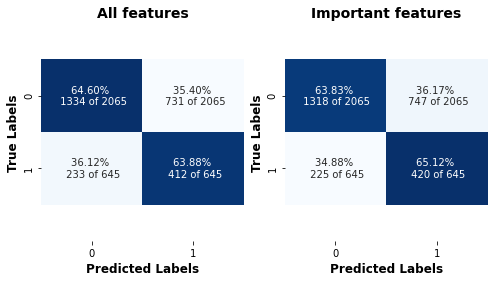

In [79]:
fig = plt.figure()
fig.set_size_inches(8, 4)
plot_confusion_matrix(gbr, X_test, y_test, ax=fig.add_subplot(1,2,1), normalize=True, title='All features')
plot_confusion_matrix(gbr1, X_test1, y_test1, ax=fig.add_subplot(1,2,2), normalize=True, title='Important features')
plt.savefig('temp.jpg')

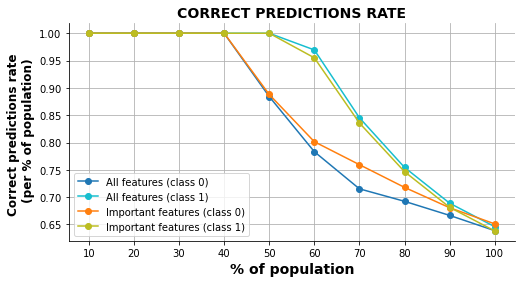

In [80]:
fig = plt.figure()
fig.set_size_inches(8, 4)
deciles = plot_cls_ratio_deciles([gbr, gbr1], [X_test, X_test1], [y_test, y_test1], [X_test.index, X_test1.index], 
                                 ax=fig.add_subplot(1,1,1), by_class=1, cumulative=True, title='CORRECT PREDICTIONS RATE',
                                 legend=['All features (class 0)', 'All features (class 1)',
                                         'Important features (class 0)', 'Important features (class 1)'])
plt.savefig('temp.jpg')

### Results analysis

In [81]:
total_mean1, lift1 = get_lift_chart_proba(gbr1, X_test1, y_test1, by_class=1)
print('Total mean: ', total_mean1, '\n')
lift1

Total mean:  0.4566156677699495 



,n_samples,dec_mean_proba,dec_lift_ovr_mean,n_cum_samples,cum_mean_proba,cum_lift_ovr_mean
0,271.0,0.760239,0.664943,271.0,0.760239,0.664943
1,271.0,0.642857,0.407873,542.0,0.701548,0.536408
2,271.0,0.574300,0.257732,813.0,0.659132,0.443516
3,271.0,0.527005,0.154154,1084.0,0.626100,0.371176
4,271.0,0.486966,0.066467,1355.0,0.598273,0.310234
5,271.0,0.409200,-0.103842,1626.0,0.566761,0.241221
6,271.0,0.325232,-0.287734,1897.0,0.532257,0.165656
7,271.0,0.300406,-0.342103,2168.0,0.503276,0.102186
8,271.0,0.285752,-0.374196,2439.0,0.479106,0.049255
9,271.0,0.254201,-0.443294,2710.0,0.456616,0.000000


In [130]:
lift1.to_csv('NewFund_cls_lift1.csv')

In [82]:
data1 = data_raw.copy()
p = gbr1.predict_proba(data_raw[X_test1.columns])
data1['proba_not_add_new_fund_2019'] = p[:,0]
data1['proba_add_new_fund_2019'] = p[:,1]

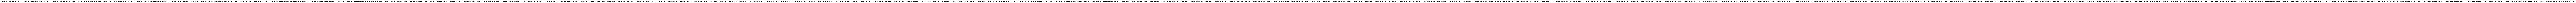

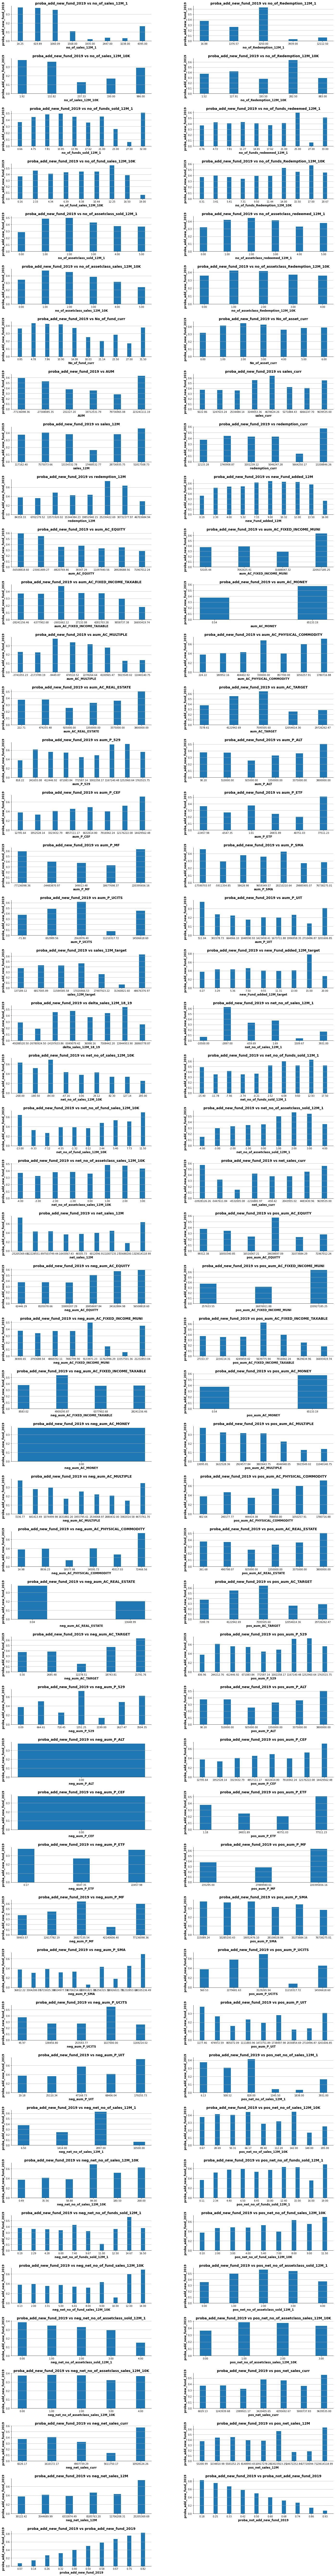

In [83]:
grd = list(data1.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data1, x=col, y='proba_add_new_fund_2019', ax=fig.add_subplot(gs[idx]))

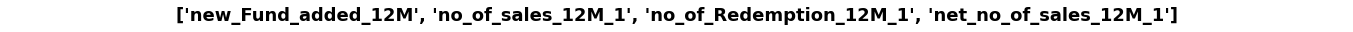

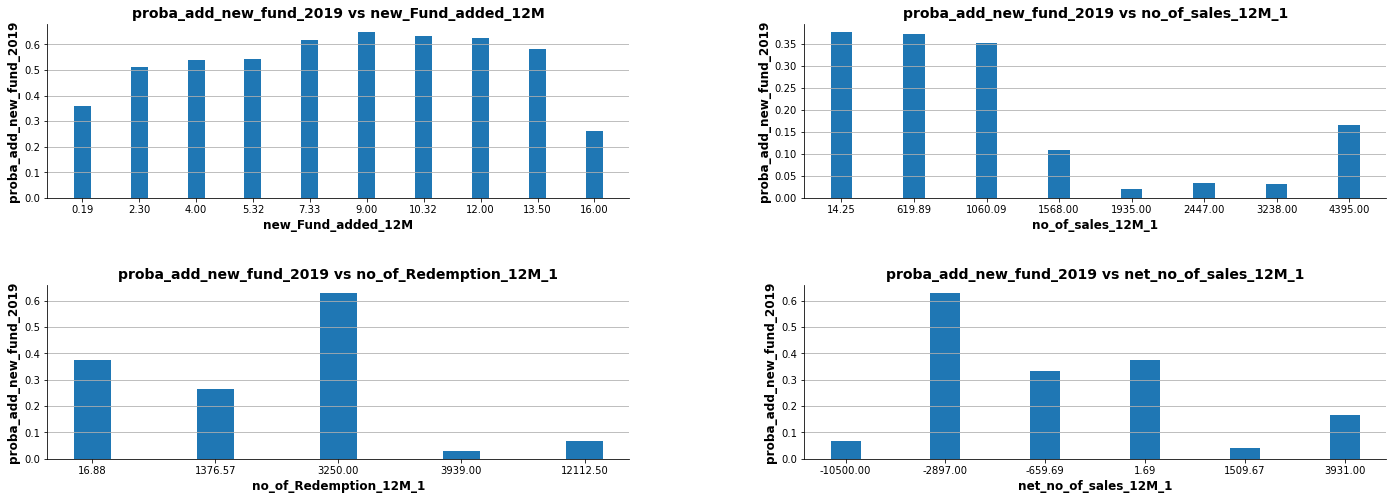

In [84]:
grd = ['new_Fund_added_12M', 'no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'net_no_of_sales_12M_1']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data1, x=col, y='proba_add_new_fund_2019', ax=fig.add_subplot(gs[idx]))

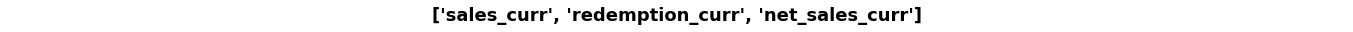

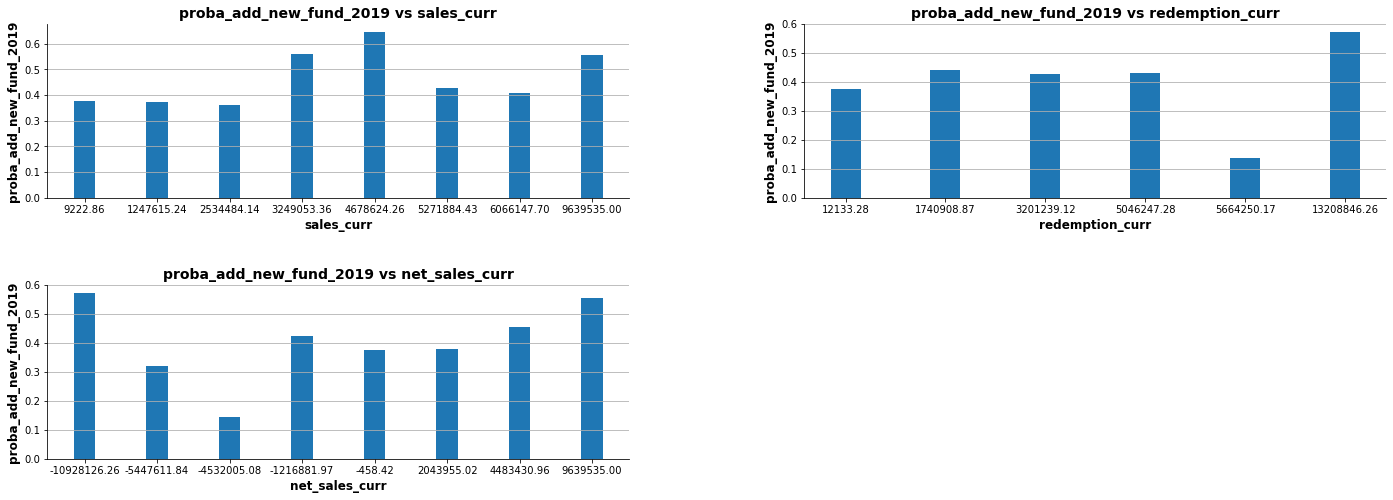

In [85]:
grd = ['sales_curr', 'redemption_curr', 'net_sales_curr']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data1, x=col, y='proba_add_new_fund_2019', ax=fig.add_subplot(gs[idx]))

In [86]:
data2 = data1.copy()
data2['aum_sum'] = data2['aum_AC_MULTIPLE'] + data2['aum_P_UIT'] + data2['aum_AC_FIXED_INCOME_TAXABLE'] + data2['aum_AC_TARGET'] + data2['aum_AC_REAL_ESTATE'] + data2['aum_P_MF']
data2['pos_aum_sum'] = data2['pos_aum_AC_MULTIPLE'] + data2['pos_aum_P_UIT'] + data2['pos_aum_AC_FIXED_INCOME_TAXABLE'] + data2['pos_aum_AC_TARGET'] + data2['pos_aum_AC_REAL_ESTATE'] + data2['pos_aum_P_MF']
data2['neg_aum_sum'] = data2['neg_aum_AC_MULTIPLE'] + data2['neg_aum_P_UIT'] + data2['neg_aum_AC_FIXED_INCOME_TAXABLE'] + data2['neg_aum_AC_TARGET'] + data2['neg_aum_AC_REAL_ESTATE'] + data2['neg_aum_P_MF']

In [87]:
# data2 = data_raw.copy()
data2['aum_ac_sum'] = data2['aum_AC_MULTIPLE'] + data2['aum_AC_FIXED_INCOME_TAXABLE'] + data2['aum_AC_TARGET'] + data2['aum_AC_REAL_ESTATE']
data2['pos_ac_aum_sum'] = data2['pos_aum_AC_MULTIPLE'] + data2['pos_aum_AC_FIXED_INCOME_TAXABLE'] + data2['pos_aum_AC_TARGET'] + data2['pos_aum_AC_REAL_ESTATE']
data2['neg_ac_aum_sum'] = data2['neg_aum_AC_MULTIPLE'] + data2['neg_aum_AC_FIXED_INCOME_TAXABLE'] + data2['neg_aum_AC_TARGET'] + data2['neg_aum_AC_REAL_ESTATE']

In [88]:
# data2 = data_raw.copy()
data2['aum_p_sum'] = data2['aum_P_UIT'] + data2['aum_P_MF']
data2['pos_p_aum_sum'] = data2['pos_aum_P_UIT'] + data2['pos_aum_P_MF']
data2['neg_p_aum_sum'] = data2['neg_aum_P_UIT'] + data2['neg_aum_P_MF']

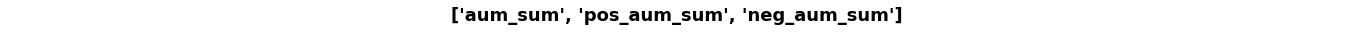

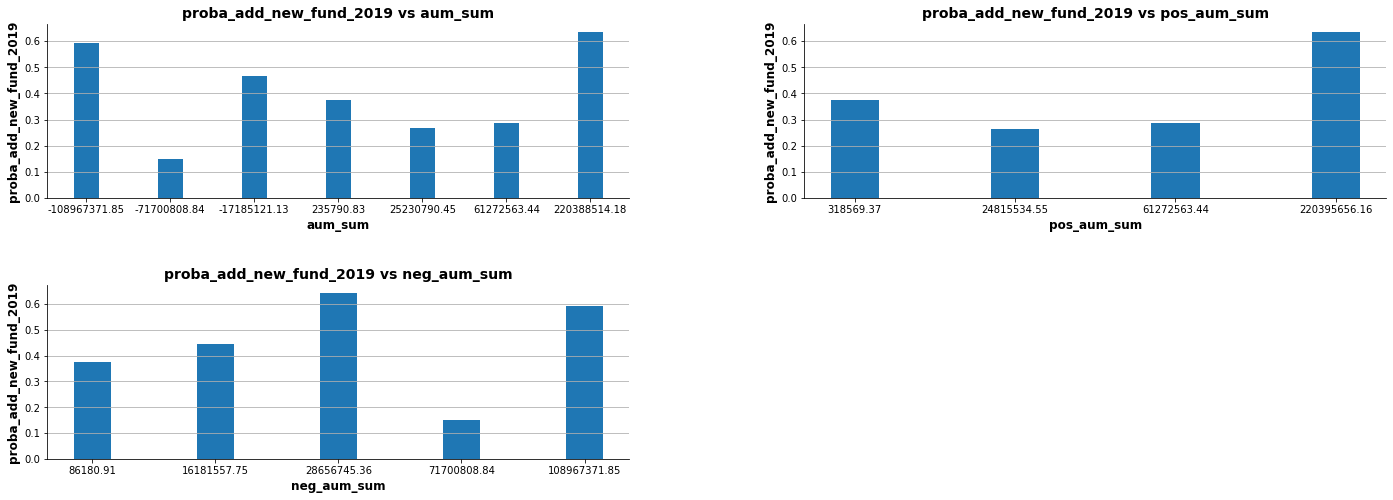

In [89]:
grd = ['aum_sum','pos_aum_sum','neg_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='proba_add_new_fund_2019', ax=fig.add_subplot(gs[idx]))

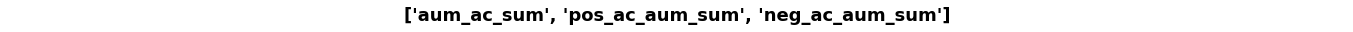

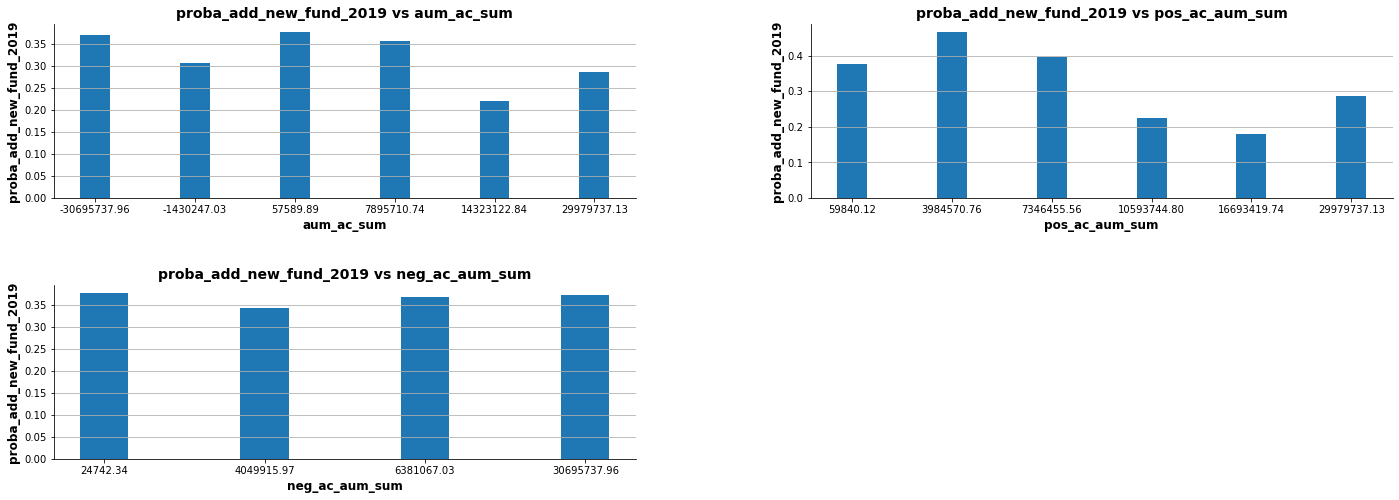

In [90]:
grd = ['aum_ac_sum','pos_ac_aum_sum','neg_ac_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='proba_add_new_fund_2019', ax=fig.add_subplot(gs[idx]))

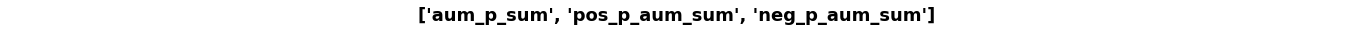

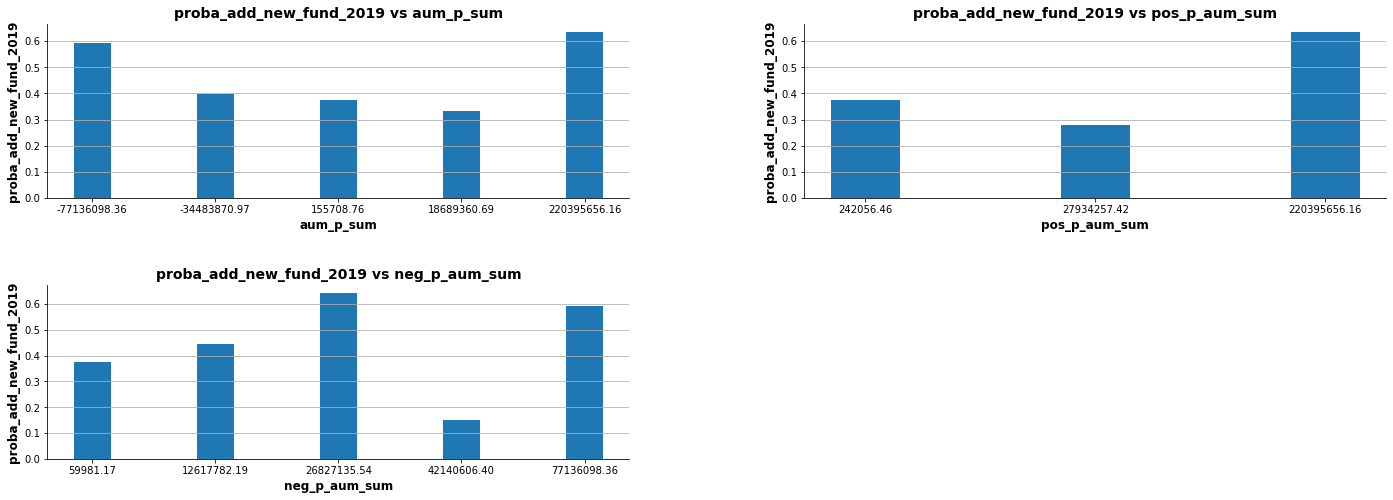

In [91]:
grd = ['aum_p_sum','pos_p_aum_sum','neg_p_aum_sum']
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 4
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, grd, fontsize=18, fontweight='bold', horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(grd):
    plot_diagram_xy(data2, x=col, y='proba_add_new_fund_2019', ax=fig.add_subplot(gs[idx]))

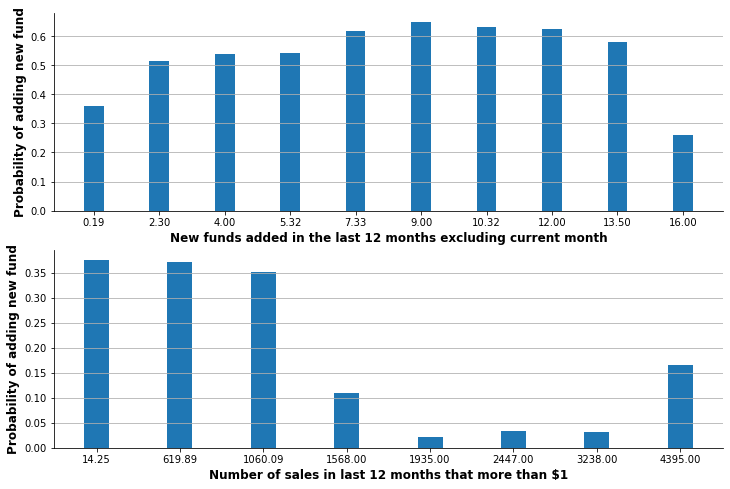

In [92]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, 
                x='new_Fund_added_12M', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='New funds added in the last 12 months excluding current month', 
                y_title='Probability of adding new fund', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, 
                x='no_of_sales_12M_1', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Number of sales in last 12 months that more than $1', 
                y_title='Probability of adding new fund', title='')

plt.savefig('temp.jpg')

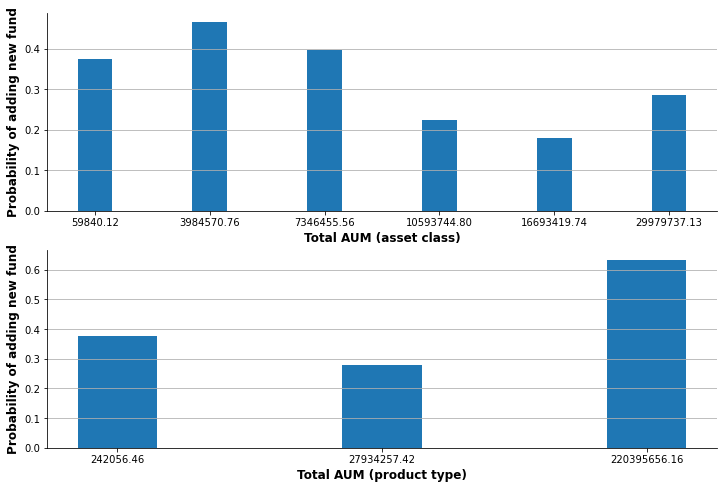

In [93]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, 
                x='pos_ac_aum_sum', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Total AUM (asset class)', 
                y_title='Probability of adding new fund', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, 
                x='pos_p_aum_sum', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Total AUM (product type)', 
                y_title='Probability of adding new fund', title='')

plt.savefig('temp.jpg')

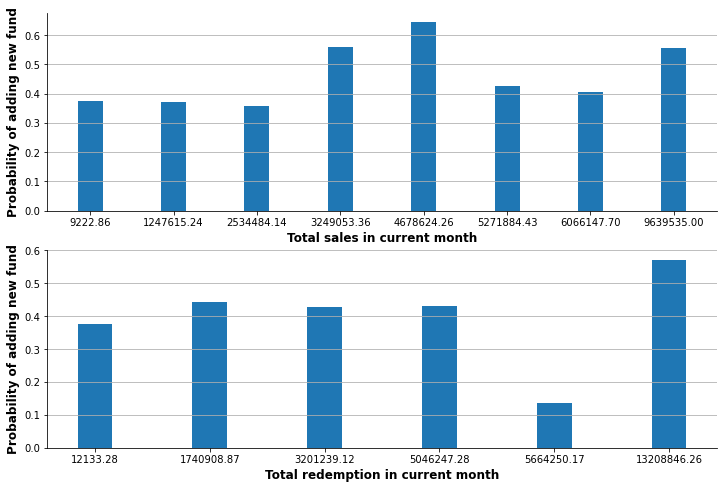

In [94]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax=fig.add_subplot(2,1,1)
plot_diagram_xy(data2, 
                x='sales_curr', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Total sales in current month', 
                y_title='Probability of adding new fund', title='')

ax=fig.add_subplot(2,1,2)
plot_diagram_xy(data2, 
                x='redemption_curr', 
                y='proba_add_new_fund_2019', 
                ax=ax, 
                x_title='Total redemption in current month', 
                y_title='Probability of adding new fund', title='')

plt.savefig('temp.jpg')

#### Conclusions

1. Advisors with higher total sales in current month have slightly higher probability of adding new fund in next 12 months.
2. Advisors that have smaller number of sales that more than \\$1 in the last 12 months are more likely to add a new fund in next year.
3. Advisors who added more funds in the last 12 months are likely to add a new fund in next year. However, those advisors who have highest number of funds added in the last 12 months are less probable to add a new fund in next year.
4. Advisors with higher total AUM in asset class MULTIPLE, FIXED INCOME TAXABLE, TARGET and REAL ESTATE have less probability of adding new fund in next 12 months. However, advisors with higher total AUM in product class UIT and MF have higher probability of adding new fund in next 12 months.